# İstanbul Lokasyanundaki Evlerin Fiyat Tahmini

## Gerekli Kütüphaneler

In [367]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

## Veri Seti İşlemleri

In [368]:
path = os.getcwd() + '\house_price_data_3500_updated_new.xlsx'

In [369]:
df = pd.read_excel(path)

In [370]:
df['Price'].fillna(0, inplace = True)
mean = df.loc[df['Price'] < 1000000, 'Price'].mean() # 1000000tl nin altındaki değerlerin medianını almak için median methodunu kullanıyorum
df.loc[df.Price > 1000000, 'Price'] = np.nan # 1000000den yüksel değerlerin valuesunun nan yapıyoruz
df['Price'].fillna(mean,inplace=True) # NaN değerleri mean ile değiştiriyoruz

In [371]:
df['Isıtma Tipi'].fillna('Yok', inplace=True) # Isıtma tipi verileri sayısal karşılıklarını çevrildi.
df['Isıtma Tipi'] = df['Isıtma Tipi'].replace({'Güneş Enerjisi': '14', 'Kombi (Doğalgaz)': '1', 'Merkezi Sistem (Isı Payı Ölçer)': '2', 'Klima':'3', 'Kalorifer (Doğalgaz)':'4', 'Merkezi Sistem':'5', 'Yerden Isıtma':'6', 'Soba (Doğalgaz)':'7', 'Kat Kaloriferi':'8', 'Soba (Kömür)':'9', 'Kalorifer (Kömür)':'10', 'Kalorifer (Akaryakıt)':'11', 'Kombi (Elektrikli)':'12', 'Yok':'13'})

In [372]:
df['Mobilya Durumu'].fillna('Eşyasız', inplace=True) # Mobilya Durumu verileri sayısal karşılıklarını çevrildi.
df['Mobilya Durumu'] = df['Mobilya Durumu'].replace({'Eşyasız': '1', 'Sadece Mutfak': '2', 'Eşyalı (Mobilyalı)': '3', 'Sadece Beyaz Eşya':'4'})

In [373]:
df['Krediye Uygun'].fillna('Hayır', inplace=True) # Krediye Uygun verileri sayısal karşılıklarını çevrildi.
df['Krediye Uygun'] = df['Krediye Uygun'].replace({'Hayır': '1', 'Evet': '2'})

In [374]:
df['Bulunduğu Kat'].fillna('0', inplace = True)
df["Bulunduğu Kat"] = df["Bulunduğu Kat"].replace({"Kot 1": "-1","Yüksek Giriş": "0","Giriş Katı": "0","Bodrum Kat": "-1","Müstakil": "0","Bahçe katı": "0","Kot 3": "-3","En Üst Kat": "10","Zemin Kat": "0","Kot 2": "-2","Çatı Katı": "10","Kot 4": "-4","20 ve üzeri": "20","Teras Kat": "20","Komple": "2"})

In [375]:
df.drop(['Location2','Location1', 'Oda Sayısı', 'Location Lat', 'Location Lon'], axis = 1, inplace = True) # Kullanılmayack veriler dataframe'den silindi

In [376]:
df['Krediye Uygun'] = df['Krediye Uygun'].astype(int)   # String tipindeki değerler üzerinde tip dönüşümü yapıldı
df['Mobilya Durumu'] = df['Mobilya Durumu'].astype(int)
df['Isıtma Tipi'] = df['Isıtma Tipi'].astype(int)
df['Bulunduğu Kat'] = df['Bulunduğu Kat'].astype(int)

In [377]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3378 entries, 0 to 3377
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brüt m²         3378 non-null   int64  
 1   Net m²          3378 non-null   int64  
 2   Oda_Sayısı_ID   3378 non-null   int64  
 3   Banyo Sayısı    3378 non-null   int64  
 4   Bulunduğu Kat   3378 non-null   int32  
 5   Bina Yaşı       3378 non-null   int64  
 6   Isıtma Tipi     3378 non-null   int32  
 7   Mobilya Durumu  3378 non-null   int32  
 8   Kira Getirisi   3378 non-null   float64
 9   Krediye Uygun   3378 non-null   int32  
 10  Price           3378 non-null   float64
 11  LocationID      3378 non-null   int64  
 12  Aidat           3378 non-null   int64  
dtypes: float64(2), int32(4), int64(7)
memory usage: 290.4 KB


In [378]:
df.head(10)

,Brüt m²,Net m²,Oda_Sayısı_ID,Banyo Sayısı,Bulunduğu Kat,Bina Yaşı,Isıtma Tipi,Mobilya Durumu,Kira Getirisi,Krediye Uygun,Price,LocationID,Aidat
0,95,90,3,1,1,1,1,1,1000.0,2,265000.0,2,1000
1,90,85,3,1,1,0,1,1,800.0,2,192000.0,2,500
2,120,110,5,1,1,0,1,1,1200.0,2,340000.0,2,83
3,60,55,2,1,1,18,1,1,1210.0,2,225000.0,3,350
4,95,85,3,1,1,5,2,1,1870.0,2,410000.0,3,750
5,73,63,3,1,1,1,1,2,1250.0,2,390000.0,3,83
6,145,130,5,2,1,0,3,1,2860.0,2,665000.0,3,0
7,130,120,5,1,1,0,4,1,1500.0,1,470000.0,3,30
8,120,90,5,2,1,0,1,1,2500.0,2,439000.0,3,0
9,160,130,7,2,1,2,1,1,2860.0,2,525000.0,3,500


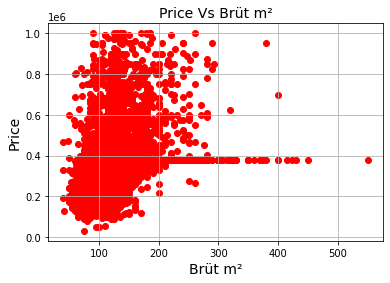

In [379]:
plt.scatter(df['Brüt m²'], df['Price'], color='red')
plt.title('Price Vs Brüt m²', fontsize=14)
plt.xlabel('Brüt m²', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

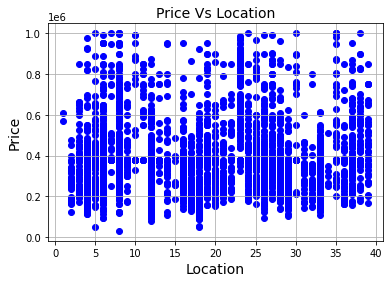

In [380]:
plt.scatter(df['LocationID'], df['Price'], color='blue')
plt.title('Price Vs Location', fontsize=14)
plt.xlabel('Location', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

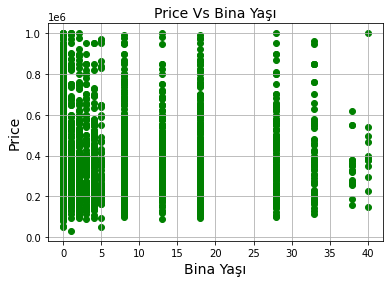

In [381]:
plt.scatter(df['Bina Yaşı'], df['Price'], color='green')
plt.title('Price Vs Bina Yaşı', fontsize=14)
plt.xlabel('Bina Yaşı', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.grid(True)
plt.show()

## Lineer Regresyon

In [382]:
X = df.drop("Price", axis=1)
Y = df["Price"]

In [383]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.3, random_state=0) # Scikit learn'ün train_test_split fonksiyonu ile test ve eğitim datalarımızı 0.3 - 0.7 oranında ayırdım

In [384]:
print (X_train.shape, y_train.shape) # Array'lerin shape'ini öğrenmek için kullanıldı

(2364, 12) (2364,)


In [385]:
linear = LinearRegression(normalize=True) # Scikit learn kütüphanesinin linearregresion fonksiyonunu linear değişkenine atandı. Veriler normalize edilmesi için parametre değeri ayarlandı.
linear.fit(X_train,y_train) # Eğitim gerçekleşti.
predictions = linear.predict(X_train) # Test verileri üzerinde prediction yapıldı.

In [386]:
pre_df = pd.DataFrame({'Real': y_train, 'Prediction':predictions})
print(pre_df.head())    # Test verisi üzerindeki tahmin sonuçları ve gerçek değerleri ekrana bastırıldı.

          Real     Prediction
1473  300000.0  313734.723845
2566  175000.0  274495.828822
2740  440000.0  386488.822559
2985  125000.0  249605.014297
1949  440000.0  323867.779112


In [387]:
coeff_df_linear = pd.DataFrame(linear.coef_, X.columns, columns=['Coefficient'])
coeff_df_linear # Eğitim sonucu ağırlıların (w) değerleri

,Coefficient
Brüt m²,562.573483
Net m²,-1023.483227
Oda_Sayısı_ID,20571.042583
Banyo Sayısı,41504.508794
Bulunduğu Kat,9610.219299
Bina Yaşı,639.125631
Isıtma Tipi,10072.076191
Mobilya Durumu,6924.114858
Kira Getirisi,19.557778
Krediye Uygun,25195.584635


In [388]:
print('Mean squared error: %.2f' % mean_squared_error(y_train, predictions)) # Train veri seti üzerinde MSE değeri
print('Training Score: %.2f' % r2_score(y_train, predictions)) # Train veri seti üzerinde accuary değeri

Mean squared error: 27730309914.61
Training Score: 0.23


In [389]:
test_data_score= linear.score(X_test,y_test) # Verilerin scorlarını (accuary) karşılaştırdım.
print("Test Score: ", test_data_score)
train_data_score = linear.score(X_train,y_train)
print("Traning Score: ", train_data_score)

Test Score:  0.22437014119153265
Traning Score:  0.22626809516988067


In [390]:
X_train=np.arange(0,len(X_train),1)#arrayi ND den 1D ye çevirdim.
X_test=np.arange(0,len(X_test),1)

In [391]:
m, b = np.polyfit(X_test, y_test, 1)

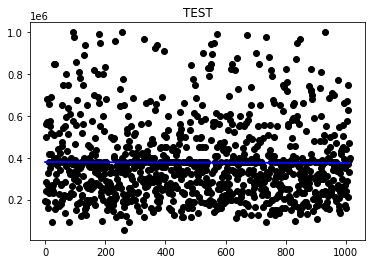

In [392]:
plt.title("TEST")
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, m*X_test+b, color='blue', linewidth=2)
#plt.plot(X_test, y_pred, color='red', linewidth=2)# çizgiyi prediction ile çekmeye çalıştım olmadı.
plt.show()

## Lineer Lasso Regresion (L1)

In [393]:
X = df.drop("Price", axis=1)
Y = df["Price"]

In [394]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.3, random_state=0) # Scikit learn'ün train_test_split fonksiyonu ile test ve eğitim datalarımızı 0.3 - 0.7 oranında ayırdım

In [395]:
lasso = Lasso(alpha=10, max_iter=10e5)
lasso.fit(X_train,y_train)
predictions = lasso.predict(X_train) # Test verileri üzerinde prediction yapıldı.

In [396]:
pre_df = pd.DataFrame({'Real': y_train, 'Prediction':predictions})
print(pre_df.head())    # Test verisi üzerindeki tahmin sonuçları ve gerçek değerleri ekrana bastırıldı.

          Real     Prediction
1473  300000.0  313864.705682
2566  175000.0  274485.563227
2740  440000.0  386451.029784
2985  125000.0  249697.450805
1949  440000.0  323914.387407


In [397]:
coeff_df_lasso = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])
coeff_df_lasso # Eğitim sonucu ağırlıların (w) değerleri

,Coefficient
Brüt m²,563.225601
Net m²,-1023.509235
Oda_Sayısı_ID,20563.116699
Banyo Sayısı,41462.708959
Bulunduğu Kat,9610.372181
Bina Yaşı,638.817704
Isıtma Tipi,10066.063941
Mobilya Durumu,6908.045076
Kira Getirisi,19.560215
Krediye Uygun,25089.275868


In [398]:
print('Mean squared error: %.2f' % mean_squared_error(y_train, predictions)) # Train veri seti üzerinde MSE değeri
print('Training Score: %.2f' % r2_score(y_train, predictions)) # Train veri seti üzerinde accuary değeri

Mean squared error: 27730311688.35
Training Score: 0.23


In [399]:
train_score=lasso.score(X_train,y_train) # Train ve test datalarının score'ları
test_score=lasso.score(X_test,y_test)
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.22626804567892844
test score:  0.22437873627399862


## Lineer Ridge Regresion (L2)

In [400]:
X = df.drop("Price", axis=1)
Y = df["Price"]

In [401]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.3, random_state=0) # Scikit learn'ün train_test_split fonksiyonu ile test ve eğitim datalarımızı 0.3 - 0.7 oranında ayırdım

In [402]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_train) # Test verileri üzerinde prediction yapıldı.

In [403]:
pre_df = pd.DataFrame({'Real': y_train, 'Prediction':predictions})
print(pre_df.head())    # Test verisi üzerindeki tahmin sonuçları ve gerçek değerleri ekrana bastırıldı.

          Real     Prediction
1473  300000.0  315101.882923
2566  175000.0  274264.570777
2740  440000.0  385857.413833
2985  125000.0  250404.680195
1949  440000.0  324697.335226


In [404]:
coeff_df_ridge = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])
coeff_df_ridge # Eğitim sonucu ağırlıların (w) değerleri

,Coefficient
Brüt m²,571.780130
Net m²,-1024.620921
Oda_Sayısı_ID,20531.218772
Banyo Sayısı,40652.938022
Bulunduğu Kat,9620.905890
Bina Yaşı,636.522721
Isıtma Tipi,10046.579873
Mobilya Durumu,6898.397749
Kira Getirisi,19.578095
Krediye Uygun,24169.790513


In [405]:
print('Mean squared error: %.2f' % mean_squared_error(y_train, predictions)) # Train veri seti üzerinde MSE değeri
print('Training Score: %.2f' % r2_score(y_train, predictions)) # Train veri seti üzerinde accuary değeri

Mean squared error: 27730566055.84
Training Score: 0.23


In [406]:
train_score=ridge.score(X_train,y_train) # Train ve test datalarının score'ları
test_score=ridge.score(X_test,y_test)
print("training score:", train_score)
print("test score: ", test_score)

training score: 0.22626094830991095
test score:  0.22433812483449167


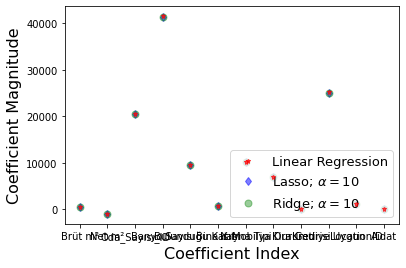

In [407]:
# Üç ayrı modelin ağırlıklarının grafikte gösterimi
plt.plot(coeff_df_linear['Coefficient'],alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Linear Regression',zorder=7) 

plt.plot(coeff_df_lasso['Coefficient'],alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 10$') 

plt.plot(coeff_df_lasso['Coefficient'],alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label=r'Ridge; $\alpha = 10$')

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()